In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import warnings
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from CustomModel import funnel_viz, MultiLevelLogisticRegression

In [3]:
pd.options.display.max_columns = 100

# Data situation and funnel

In [5]:
# https://www.kaggle.com/arashnic/banking-loan-prediction
df = pd.read_csv('bank_marketing/train.csv')
df['Contacted'] = (df['Contacted'] == 'Y').astype(int)
df

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,B001,P,0,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,Male,07/12/86,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,B002,P,1,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,Male,10/12/82,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,B003,G,1,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0
3,APPF80273865537,Male,30/01/89,09/07/16,C10477,C,COM0004143,A,4.0,3500.0,B003,G,1,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0
4,APPG60994436641,Male,19/04/85,20/07/16,C10002,A,COM0001781,A,4.0,10000.0,B001,P,1,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,31/07/83,30/09/16,C10006,A,COM0000010,A,1.0,4900.0,B002,P,0,S122,G,0.0,NaN,NaN,NaN,NaN,10,0
69709,APPV80989824738,Female,27/01/71,30/09/16,C10116,C,COM0045789,A,4.0,7190.1,B002,P,0,S122,G,1450.0,NaN,NaN,NaN,NaN,7,0
69710,APPW50697209842,Female,01/02/92,30/09/16,C10022,B,COM0013284,C,4.0,1600.0,B030,P,1,S122,G,0.0,24000.0,4.0,35.50,943.0,2,0
69711,APPY50870035036,Male,27/06/78,30/09/16,C10002,A,COM0000098,C,3.0,9893.0,B002,P,1,S122,G,1366.0,80000.0,5.0,NaN,NaN,10,0


In [6]:
# percentage who got called
df['Contacted'].mean()

0.6494484529427796

In [7]:
# percentage who were approved (out of total versus only out those called)
# It looks like the bank is calling people randomly (can vastly improve conversion by calling in targetted manner)
df['Approved'].mean(), df.loc[df['Contacted'] == 1, 'Approved'].mean()

(0.014631417382697631, 0.018707896189950304)

In [8]:
# the 'funnel' is not perfectly clean since there are some approved without being called
pd.crosstab(df['Contacted'], df['Approved'])

Approved,0,1
Contacted,,
0,24265,173
1,44428,847


In [9]:
pop_size = len(df)
steps = 2
conversion_rates = [df['Contacted'].mean(), df.loc[df['Contacted'] == 1, 'Approved'].mean()]
step_labels = ['called', 'approved']
assert steps >= 1
assert steps == len(conversion_rates)
assert len(step_labels) == len(conversion_rates)

<AxesSubplot:>

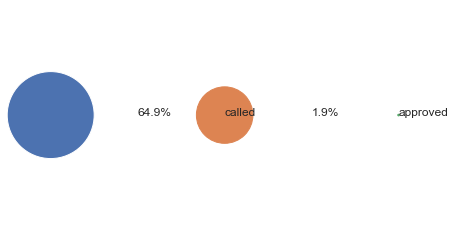

In [10]:
funnel_viz(steps, conversion_rates, step_labels)

# Preprocessing for model

In [11]:
feature_cols = ['Monthly_Income','Existing_EMI']
target_cols = ['Contacted','Approved']
df_proc = df[feature_cols + target_cols]
df_proc.fillna(0, inplace=True)
# Rename columns to work with the model class
target_cols = ['level_1','level_2']
df_proc.columns = feature_cols + target_cols
df_proc

C:\Users\R\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Monthly_Income,Existing_EMI,level_1,level_2
0,2000.0,0.0,0,0
1,3500.0,0.0,1,0
2,2250.0,0.0,1,0
3,3500.0,0.0,1,0
4,10000.0,2500.0,1,0
...,...,...,...,...
69708,4900.0,0.0,0,0
69709,7190.1,1450.0,0,0
69710,1600.0,0.0,1,0
69711,9893.0,1366.0,1,0


<AxesSubplot:xlabel='level_1', ylabel='Existing_EMI'>

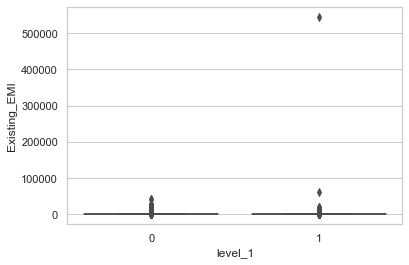

In [12]:
sns.boxplot(data=df_proc, y='Existing_EMI', x='level_1')

<AxesSubplot:xlabel='level_2', ylabel='Existing_EMI'>

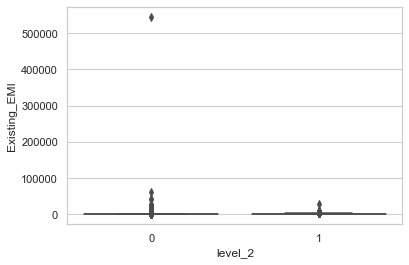

In [13]:
sns.boxplot(data=df_proc, y='Existing_EMI', x='level_2')

# Modeling

In [14]:
clf = MultiLevelLogisticRegression(steps, LogisticRegression)

In [24]:
clf.fit(df_proc[feature_cols], df_proc[target_cols])

Fitting level_1 model with 69,713 datapoints and 64.9% class mean.
Fitting level_2 model with 45,275 datapoints and 1.9% class mean.


MultiLevelLogisticRegression(clf_cls=<class 'sklearn.linear_model._logistic.LogisticRegression'>,
                             clf_kws={}, steps=2)

In [16]:
preds = clf.predict(df_proc[feature_cols])
preds

,pred_level_1,pred_level_2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
69708,1,0
69709,1,0
69710,1,0
69711,1,0


In [17]:
pd.crosstab(preds['pred_level_1'], preds['pred_level_2'])

pred_level_2,0,1
pred_level_1,,
0,8570,48
1,61091,4


In [18]:
# the conversion for demo stage has been underestimated while the conversion from demo to close (conditioned on demo) is overestimated
preds['pred_level_1'].mean(), preds['pred_level_2'].mean(), preds.loc[preds['pred_level_1'] == 1, 'pred_level_2'].mean()

(0.8763788676430508, 0.0007459153959806636, 6.547180620345364e-05)

In [19]:
probs = clf.predict_proba(df_proc[feature_cols])
probs

,pred_prob_level_1,pred_prob_level_2
0,0.671855,0.017155
1,0.777996,0.016717
2,0.691291,0.017081
3,0.777996,0.016717
4,0.694419,0.038509
...,...,...
69708,0.852662,0.016318
69709,0.725948,0.027223
69710,0.639517,0.017274
69711,0.884464,0.025183


# Analysis of results

In [20]:
df_preds = pd.concat([df_proc.assign(target=lambda d: d['level_1'].astype(str)+'_'+d['level_2'].astype(str)), preds, probs], axis=1)
df_preds['target'] = df_preds['target'].map(dict(zip(['0_0','1_0','0_1','1_1'],['Nothing','Call, no approval', 'Approval without call', 'Call then approval'])))
df_preds['target'] = df_preds['target'].astype('category')
df_preds['target'] = df_preds['target'].cat.reorder_categories(['Nothing','Call, no approval', 'Approval without call', 'Call then approval'], ordered=True)
df_preds = df_preds.rename_axis('cid', axis=0).reset_index()
df_preds

,cid,Monthly_Income,Existing_EMI,level_1,level_2,target,pred_level_1,pred_level_2,pred_prob_level_1,pred_prob_level_2
0,0,2000.0,0.0,0,0,Nothing,1,0,0.671855,0.017155
1,1,3500.0,0.0,1,0,"Call, no approval",1,0,0.777996,0.016717
2,2,2250.0,0.0,1,0,"Call, no approval",1,0,0.691291,0.017081
3,3,3500.0,0.0,1,0,"Call, no approval",1,0,0.777996,0.016717
4,4,10000.0,2500.0,1,0,"Call, no approval",1,0,0.694419,0.038509
...,...,...,...,...,...,...,...,...,...,...
69708,69708,4900.0,0.0,0,0,Nothing,1,0,0.852662,0.016318
69709,69709,7190.1,1450.0,0,0,Nothing,1,0,0.725948,0.027223
69710,69710,1600.0,0.0,1,0,"Call, no approval",1,0,0.639517,0.017274
69711,69711,9893.0,1366.0,1,0,"Call, no approval",1,0,0.884464,0.025183


In [21]:
# common_cols = feature_cols + ['target']
common_cols = ['cid','target']
a = pd.melt(df_preds, id_vars=common_cols, value_vars=target_cols, var_name='level', value_name='final_level')
b = pd.melt(df_preds, id_vars=common_cols, value_vars=[f"pred_prob_{l}" for l in target_cols], var_name='level', value_name='pred_level')
m = pd.merge(a, b, how='outer', on=common_cols)
m

,cid,target,level_x,final_level,level_y,pred_level
0,0,Nothing,level_1,0,pred_prob_level_1,0.671855
1,0,Nothing,level_1,0,pred_prob_level_2,0.017155
2,0,Nothing,level_2,0,pred_prob_level_1,0.671855
3,0,Nothing,level_2,0,pred_prob_level_2,0.017155
4,1,"Call, no approval",level_1,1,pred_prob_level_1,0.777996
...,...,...,...,...,...,...
278847,69711,"Call, no approval",level_2,0,pred_prob_level_2,0.025183
278848,69712,"Call, no approval",level_1,1,pred_prob_level_1,0.819887
278849,69712,"Call, no approval",level_1,1,pred_prob_level_2,0.016508
278850,69712,"Call, no approval",level_2,0,pred_prob_level_1,0.819887


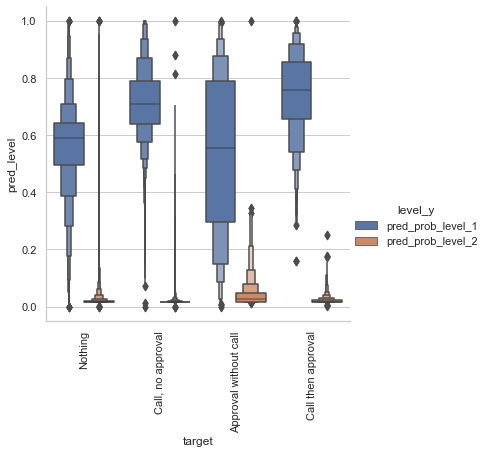

In [22]:
sns.catplot(data=m, kind='boxen',
            x='target', y='pred_level', hue='level_y')
plt.xticks(rotation=90);

In [23]:
clf.feature_importance(feature_cols)

,level_1,level_2
Monthly_Income,0.000358,-0.000018
Existing_EMI,-0.001105,0.000388
